### What is ensemble?

Ensemble learning is a general approach to machine learning that seeks better predictive performance by combining the predictions from multiple models.


In [1]:
import pandas as pd

df = pd.read_csv('./data/sales.csv')
df.dropna(subset=['price'], inplace=True)

In [2]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [3]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

# 1. Random Forest

<font color='red'>Assignment:</font> Build a pipeline with **RandomForestRegressor** to predict **price** with **cost**, **weight**, **height**, **width**, **depth**, and **volume**.

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
from sklearn.base import TransformerMixin

class Transformer(TransformerMixin):
    '''
    A transformer class to extract numerical features
    (cost, weight, height, width, and depth) and replace
    the missing values with the averages in train data
    '''

    def __init__(self):  # maybe can use super() since it is inheritance?
        self.mean = 0
    
    def fit(self, X, y=None):
        '''
        Get mean
        Input: X datafrome
        '''
        df = pd.DataFrame()
        df['cost'] = X['cost'].map(self.cost2num)
        df['weight'] = X['weight'].map(self.weight2num)
        df['height'] = X['height'].map(self.height2num)
        df['width'] = X['width'].map(self.width2num)        
        df['depth'] = X['depth'].map(self.depth2num)
        df['volume'] = 100 * df['height'] * df['width'] * df['depth']
        self.mean = df.mean()

    def transform(self, X, y=None):
        '''
        Transform data and fill na with mean
        Input: X dataframe
        '''
        df = pd.DataFrame()
        df['cost'] = X['cost'].map(self.cost2num)
        df['weight'] = X['weight'].map(self.weight2num)
        df['height'] = X['height'].map(self.height2num)
        df['width'] = X['width'].map(self.width2num)        
        df['depth'] = X['depth'].map(self.depth2num)
        df['volume'] = 100 * df['height'] * df['width'] * df['depth']
        return df.fillna(self.mean)
 
    def fit_transform(self, X, y=None):
        '''
        Combine fit and transform
        Input: X dataframe
        '''        
        self.fit(X)
        return self.transform(X)
        
    # Convert cost string to numeric (unit: $)        
    def cost2num(self, x):
        if type(x) == str:
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x

    # Convert weight string to numeric (unit: kg)
    def weight2num(self, x):
        if type(x) == str:
            x = x.strip('Kg').strip().split(' Ton ')
            return float(x[0])*1000+float(x[1])
        else:
            return x
    
    # Convert height string to numeric (unit: cm)
    def height2num(self, x):
        if type(x) == str:
            x = x.strip('meters').strip()
            return float(x)*100
        else:
            return x        
    
    # Convert width string to numeric (unit: cm)
    def width2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x   

    # Convert depth string to numeric (unit: cm)
    def depth2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x   

In [6]:
features = list(train_raw.columns)
target = 'price'
features.remove(target)

In [7]:
def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

In [8]:
X_train = train_raw[features]
y_train = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

In [9]:
steps = [('tf', Transformer()),
         ('tree', RandomForestRegressor())]
model = Pipeline(steps)

In [10]:
model.fit(X_train, y_train)

Pipeline(steps=[('tf', <__main__.Transformer object at 0x000001F78F876E50>),
                ('tree', RandomForestRegressor())])

<font color='red'>Assignment:</font> Calculate the train/test scores.

In [11]:
y_train_pred = model.predict(X_train)

In [12]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 4.36e+04
train MSE: 4.46e+09
train R2: 0.895


In [13]:
y_test_pred = model.predict(X_test)

In [14]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.28e+05
test MSE: 5.44e+10
test R2: 0.368


<font color='red'>Assignment:</font> Plot the feature importance in a bar chart.

In [15]:
import matplotlib.pylab as plt
%matplotlib inline

In [16]:
importances = model.steps[1][1].feature_importances_

In [17]:
importances

array([0.4639296 , 0.13484549, 0.11833494, 0.06969547, 0.02397702,
       0.18921747])

([<matplotlib.axis.XTick at 0x1f791476af0>,
 [Text(0, 0, 'cost'),
  Text(1, 0, 'weight'),
  Text(2, 0, 'height'),
  Text(3, 0, 'width'),
  Text(4, 0, 'depth'),
  Text(5, 0, 'volume')])

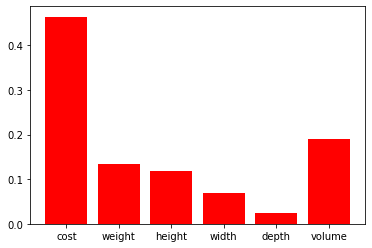

In [18]:
plt.bar(range(len(importances)), importances, color="r", align = "center")
plt.xticks(range(len(importances)), ['cost', 'weight', 'height', 'width', 'depth', 'volume'])

### Why random forest?

To overcome the overfitting issue of single decision trees, but keep the simplicity of decision tree algorithm. Fast and robust, can be used as baseline model.

<font color='red'>Question:</font> How does Random Forest work?

### Random Forest is a supervised learning algorithm. It is an ensemble of Decision Trees, most of the time trained with the “bagging” method. Random forest builds multiple decision trees and merges the prediction results together to get a more accurate and stable prediction. Random Forest adds additional randomness to the model, while growing the trees. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features.

<font color='red'>Question:</font> Why is Random Forest better than a single decision tree?

### An individual tree tends to overfit to the training data. The random forest takes an average of all the individual decision tree estimates, which leads to more robust overall predictions.

<font color='red'>Question:</font> How does Random Forest decrease model error? How does it affect bias and variance?

### The basic idea behind Random Forest is to combine multiple decision trees in determining the final output rather than relying on individual decision trees. Each decision tree in the forest considers a random subset of features when forming nodes and only has access to a random set of the training data points. Therefore, Random Forest average together a number of weakly correlated trees to reduce variance in predictions.

### Randomness comes from two sources:
- Each decision tree in the forest considers a random subset of features
- Each decision tree in the forest only has access to a random set of the training data points (see "bagging" below)

### Each tree can be deep (low bias high variance), and the averaging process reduces variance while maintaining (to some extent) the low bias. There is trade-off between bias and variance.

<font color='red'>Question:</font> What is Bagging?

### Bagging (Bootstrap Aggregating) is designed to reduce variance and help to avoid overfitting. Bagging uses the insight that a suitably large number of uncorrelated errors average out to zero. Bagging chooses multiple random samples of observations from the training data, with replacement, constructing a tree from each one. Since each tree learns from different data, they are fairly uncorrelated from one another. The final predicted value is the average value of all these decision trees. 

### What is bootstrap?

Bootstrap is a resampling technique used to estimate statistics on a population by sampling a dataset with replacement. 

Why with replacement: https://stats.stackexchange.com/questions/171440/bootstrap-methodology-why-resample-with-replacement-instead-of-random-subsamp

### What is out of bag (OOB) samples? What is out of bag score?

While making the samples during bootstrapping, samples are chosen randomly and with replacement. The samples that are not chosen are of out bag samples.

The OOB_score is computed as the number of correctly predicted rows from the out-of-bag sample.

<font color='red'>Assignment:</font> Tune hyperparameters with k-fold cross validation to optimize model performance.

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [20]:
#don't write too long lines, it's hard to read  PEP8
#the starting point should be close to sklearn default values
#first do a coarse search
#find out the variance/bias trend for each parameter, and know the direction to tune
#then do a fine search
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
parameters = {
              'rf__max_depth': [3, 6, 9, 20, 50, 100], #default is None, which means infinity
              'rf__min_samples_leaf': [1, 3, 5, 10, 20],
              'rf__min_samples_split': [2, 3, 5, 8]
             }

In [21]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

In [22]:
steps = [('tf', Transformer()),
         ('rf', RandomForestRegressor(n_estimators=50,n_jobs=-1))]
model = Pipeline(steps)

In [23]:
model_gsv = GridSearchCV(model,
                         parameters,
                         cv = 3,
                         scoring = scorer,
                         n_jobs=-1,
                         return_train_score=True)

In [24]:
model_gsv = model_gsv.fit(X_train, y_train)

In [25]:
model_gsv.best_score_

-27608175571.788025

In [26]:
model_gsv.cv_results_

{'mean_fit_time': array([0.22366571, 0.3079985 , 0.23408333, 0.21958796, 0.26608531,
        0.2703325 , 0.23666628, 0.26555943, 0.24017477, 0.26766809,
        0.238331  , 0.26699917, 0.27699892, 0.25799823, 0.2763327 ,
        0.25466426, 0.26000023, 0.2543327 , 0.25033188, 0.28466598,
        0.26300224, 0.30233177, 0.31799936, 0.32333819, 0.31633258,
        0.3613375 , 0.29136602, 0.32937264, 0.30066593, 0.33199946,
        0.32499846, 0.31733282, 0.3263336 , 0.35499652, 0.30166411,
        0.32500021, 0.27633365, 0.26499907, 0.30633235, 0.33333389,
        0.31366595, 0.33000151, 0.35433133, 0.35299961, 0.33233333,
        0.41366768, 0.33199747, 0.38066721, 0.3040007 , 0.35999997,
        0.32800062, 0.30366715, 0.35133227, 0.30099781, 0.35422953,
        0.31926878, 0.3326687 , 0.32733266, 0.29366565, 0.32099978,
        0.42399955, 0.45666671, 0.42300042, 0.37733364, 0.42400058,
        0.39700063, 0.44666449, 0.43333236, 0.43266694, 0.39900231,
        0.31299686, 0.41066726,

In [27]:
model_gsv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_rf__max_depth', 'param_rf__min_samples_leaf', 'param_rf__min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [28]:
model_gsv.param_grid

{'rf__max_depth': [3, 6, 9, 20, 50, 100],
 'rf__min_samples_leaf': [1, 3, 5, 10, 20],
 'rf__min_samples_split': [2, 3, 5, 8]}

In [29]:
#function previous student
#this function doesn't support None as a parameter input
import matplotlib.pyplot as plt
import numpy as np
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']
    params = grid.param_grid
    
    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))              ##
    
    params=grid.param_grid   
    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    
    pram_preformace_in_best = {}                         #{}

    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])           ##
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        #  best_index   [ 1  4  7 10 13 16 19 22]
        #print(best_index)
        
        #print(params[p])
        
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

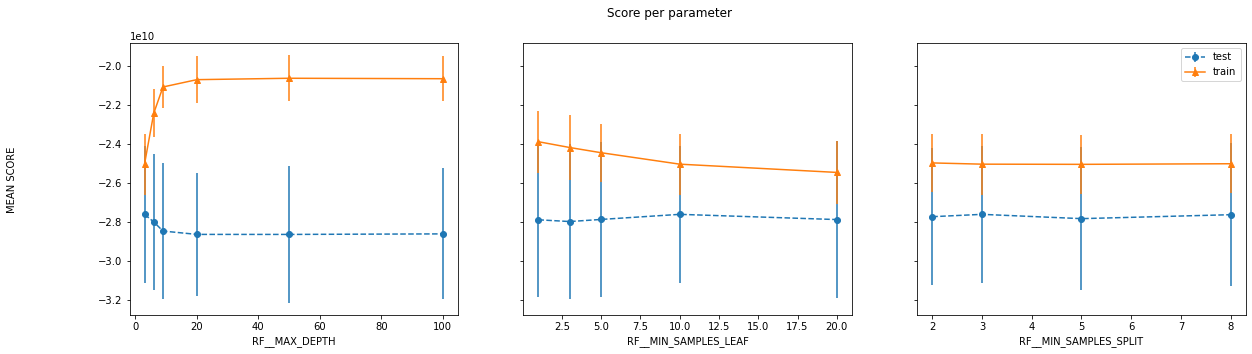

In [30]:
plot_search_results(model_gsv)

In [31]:
model_gsv.best_estimator_

Pipeline(steps=[('tf', <__main__.Transformer object at 0x000001F79180C070>),
                ('rf',
                 RandomForestRegressor(max_depth=3, min_samples_leaf=10,
                                       min_samples_split=3, n_estimators=50,
                                       n_jobs=-1))])

In [32]:
y_train_pred = model_gsv.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.04e+05
train MSE: 2.53e+10
train R2: 0.406


In [33]:
y_test_pred = model_gsv.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.30e+05
test MSE: 5.49e+10
test R2: 0.364


<font color='red'>Question:</font> What are the hyper parameters which can effetively affect model performance? How do they affect the performance respectively?

### I have tuned: 
### (1) n_estimators: the number of trees. The more the better until it becomes too many.
Usually you don't need to tune n_estimators, it's always higher the better.
Only drawback is training speed and prediction speed

When tuning hyperparameter in RF you can keep some overfitting and increase n_estimators to deal with it later.
### (2) (3) (4) are same as Decision Tree.

## Pros and cons of random forest models?
Pros: 
- Relatively low bias and variance: still possible to overfit for noisy data. 
- Robust to outliers and non-linear data.
- Parallelizable: multiple machines can share the working load and run the same forest simultaneously.

Cons: 
- Time and space consuming with large datasets. 
- Model interpretability: they provide feature importance but it does not provide complete visibility into the coefficients as linear regression.

Reading: https://medium.datadriveninvestor.com/random-forest-pros-and-cons-c1c42fb64f04


# 2. Gradient Boosting Trees

<font color='red'>Assignment:</font> Build a pipeline with **GradientBoostingRegressor** to predict **price** with **cost**, **weight**, **height**, **width**, **depth**, and **volume**.

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
steps = [('tf', Transformer()),
         ('gbr', GradientBoostingRegressor())]
model = Pipeline(steps)

In [36]:
model.fit(X_train, y_train)

Pipeline(steps=[('tf', <__main__.Transformer object at 0x000001F791C74B50>),
                ('gbr', GradientBoostingRegressor())])

<font color='red'>Assignment:</font> Calculate the train/test scores.

In [37]:
y_train_pred = model.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 9.34e+04
train MSE: 1.89e+10
train R2: 0.556


In [38]:
y_test_pred = model.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.26e+05
test MSE: 5.45e+10
test R2: 0.368


<font color='red'>Assignment:</font> Plot the feature importance in a bar chart.

In [39]:
importances = model.steps[1][1].feature_importances_
importances

array([0.70646726, 0.07414937, 0.04424945, 0.01677208, 0.00183124,
       0.1565306 ])

([<matplotlib.axis.XTick at 0x1f791a55d30>,
 [Text(0, 0, 'cost'),
  Text(1, 0, 'weight'),
  Text(2, 0, 'height'),
  Text(3, 0, 'width'),
  Text(4, 0, 'depth'),
  Text(5, 0, 'volume')])

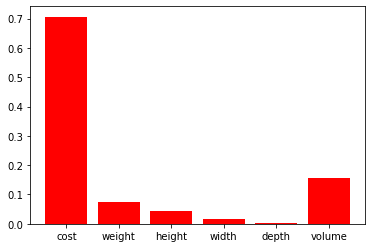

In [40]:
plt.bar(range(len(importances)), importances, color="r", align = "center")
plt.xticks(range(len(importances)), ['cost', 'weight', 'height', 'width', 'depth', 'volume'])

<font color='red'>Question:</font> How does gradient boosting tree work? 

### (1) First model data with simple models and analyze data for errors. 
### (2) These errors signify data points that are difficult to fit by a simple model. 
### (3) Then for later models, we particularly focus on those hard to fit data to get them right using gradient descent. $y^{p}_{i} = y^{p}_{i} - 2\alpha \sum(y_{i} - y^{p}_{i})$
### (4) In the end, we combine all the predictors by giving some weights to each predictor.

If you are curious to read more:

Gradient boosting involves three elements: (1) a loss function to be optimized, (2) a weak learner to make predictions, and (3) an additive model to add weak learners to minimize the loss function. 
- The loss function used depends on the type of problem being solved. It must be differentiable. For example, regression may use a squared error.
- Decision trees are used as the weak learner in gradient boosting. The outputs of sub-models (decision trees) are added together, allowing subsequent trees outputs to be added and "correct" the residuals in the predictions. Trees are constructed in a greedy manner, choosing the best split points based on purity scores like Gini or to minimize the loss. It is common to constrain the weak learners in specific ways, such as a maximum number of layers, nodes, splits or leaf nodes.
- Trees are added one at a time, and existing trees in the model are not changed. A gradient descent procedure is used to minimize the loss when adding trees. After calculating the loss of exisitng trees, we add a tree to the model that reduces the loss (i.e., follow the gradient).  We do this by parameterizing the tree, then modify the parameters of the tree and move in the right direction by reducing the residual loss. The output for the new tree is then added to the output of the existing sequence of trees in an effort to correct or improve the final output of the model. A fixed number of trees are added or training stops once loss reaches an acceptable level or no longer improves on an external validation dataset.

Ref: https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

<font color='red'>Question:</font> What is boosting?

### Boosting is an ensemble technique in which the predictors are not made independently, but sequentially. This technique employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors.  Boosting algorithms seek to improve the prediction power by training a sequence of weak models, each compensating the weaknesses of its predecessors.

<font color='red'>Question:</font> Compare gradient boosting trees and random forest. What are the pros and cons of these two models?

### Gradeint Boosting: pros: generally better performance, more accurate
### Cons: easy to overfit, takes time to train and hard to tune
### Random forest: pros: fast, OK performance, easy to tune
### Cons: bias towards categorical features that has many levels, somewhat slow at prediction time

<font color='red'>Assignment:</font> Tune hyperparameters with k-fold cross validation to optimize model performance.

In [41]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [42]:
parameters = {'gbr__learning_rate': [0.1], 
              'gbr__n_estimators': [100, 300, 500], 
              'gbr__max_depth': [3, 5, 10], 
              'gbr__min_samples_leaf': range(30, 150, 30), 
              'gbr__min_samples_split': [2, 3, 5]}

In [43]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

In [44]:
steps = [('tf', Transformer()),
         ('gbr', GradientBoostingRegressor())]
model = Pipeline(steps)

In [45]:
model_gsv = GridSearchCV(model, parameters, cv = 3, scoring = scorer, n_jobs=-1)

In [46]:
model_gsv = model_gsv.fit(X_train, y_train)

In [47]:
model_gsv.best_params_

{'gbr__learning_rate': 0.1,
 'gbr__max_depth': 3,
 'gbr__min_samples_leaf': 60,
 'gbr__min_samples_split': 2,
 'gbr__n_estimators': 100}

In [48]:
y_train_pred = model_gsv.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.00e+05
train MSE: 2.39e+10
train R2: 0.438


In [49]:
y_test_pred = model_gsv.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.24e+05
test MSE: 5.36e+10
test R2: 0.378


<font color='red'>Question:</font> What are the hyper parameters which can effetively affect model performance? How do they affect the performance respectively?

### The only extra one is the learning_rate. Lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well. Lower values would require higher number of trees to model all the relations and will be computationally expensive.

Other common hyperparameters to tune, in addition to learning_rate:

1. min_samples_split
- Defines the minimum number of samples which are required in a node to be considered for splitting. 
- Used to control overfitting. Higher values prevent overfitting. Too high values can lead to under-fitting hence, it should be tuned using CV.

2. max_depth
- The maximum depth of a tree.
- Used to control overfitting. Higher depth will allow model to learn relations very specific to a particular sample. Should be tuned using CV.

3. n_estimators
- The number of sequential trees to be modeled.
- Though GBM is fairly robust at higher number of trees but it can still overfit at a point. Hence, this should be tuned using CV for a particular learning rate.

4. subsample
- The fraction of observations to be selected for each tree. Selection is done by random sampling.
- Values slightly less than 1 make the model robust by reducing the variance. Typical values ~0.8 generally work fine but can be fine-tuned further.

5. random_state
- The random number seed so that same random numbers are generated every time. 
- This is important for parameter tuning. If we don’t fix the random number, then we’ll have different outcomes for subsequent runs on the same parameters and it becomes difficult to compare models. It can potentially result in overfitting to a particular random sample selected. We can try running models for different random samples, which is computationally expensive and generally not used.


# 3. Xgboost,  XGB=GB + regularization + parallel

<font color='red'>Assignment:</font> Build a pipeline with **XGBRegressor** to predict **price** with **cost**, **weight**, **height**, **width**, **depth**, and **volume**.

In [50]:
from xgboost.sklearn import XGBRegressor

In [51]:
steps = [('tf', Transformer()),
         ('xgbr', XGBRegressor())]     # https://xgboost.readthedocs.io/en/stable/python/python_api.html#
model = Pipeline(steps)

In [52]:
model.fit(X_train, y_train)    

Pipeline(steps=[('tf', <__main__.Transformer object at 0x000001F791A15640>),
                ('xgbr',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

<font color='red'>Assignment:</font> Calculate the train/test scores.

In [53]:
y_train_pred = model.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 4.38e+04
train MSE: 4.12e+09
train R2: 0.903


In [54]:
y_test_pred = model.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.35e+05
test MSE: 5.87e+10
test R2: 0.319


<font color='red'>Assignment:</font> Plot the feature importance in a bar chart.

In [55]:
importances = model.steps[1][1].feature_importances_
importances

array([0.3532355 , 0.09854586, 0.10043959, 0.18953238, 0.08759644,
       0.17065029], dtype=float32)

([<matplotlib.axis.XTick at 0x1f79184bdf0>,
 [Text(0, 0, 'cost'),
  Text(1, 0, 'weight'),
  Text(2, 0, 'height'),
  Text(3, 0, 'width'),
  Text(4, 0, 'depth'),
  Text(5, 0, 'volume')])

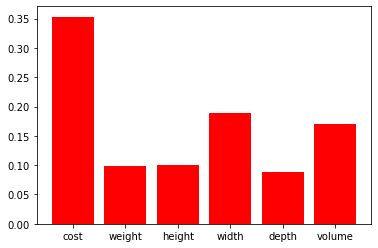

In [56]:
plt.bar(range(len(importances)), importances, color="r", align = "center")
plt.xticks(range(len(importances)), ['cost', 'weight', 'height', 'width', 'depth', 'volume'])

<font color='red'>Assignment:</font> Tune hyperparameters with k-fold cross validation to optimize model performance.

In [57]:
parameters = {'xgbr__gamma': [0.0, 0.1, 0.2, 0.3], 
              'xgbr__learning_rate': [0.05, 0.1], 
              'xgbr__n_estimators': [100, 300, 500], 
              'xgbr__max_depth': [3, 5, 10], 
              'xgbr__lambda': [0.5, 1, 5], 
              'xgbr__min_child_weight': [3, 5, 7]}

In [58]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

In [59]:
steps = [('tf', Transformer()),
         ('xgbr', XGBRegressor())]
model = Pipeline(steps)

In [60]:
model_gsv = GridSearchCV(model, parameters, cv = 5, scoring = scorer)

In [61]:
model_gsv = model_gsv.fit(X_train, y_train)

In [62]:
model_gsv.best_params_

{'xgbr__gamma': 0.0,
 'xgbr__lambda': 1,
 'xgbr__learning_rate': 0.05,
 'xgbr__max_depth': 3,
 'xgbr__min_child_weight': 7,
 'xgbr__n_estimators': 100}

In [63]:
y_train_pred = model_gsv.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 9.85e+04
train MSE: 2.23e+10
train R2: 0.476


In [64]:
y_test_pred = model_gsv.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.24e+05
test MSE: 5.44e+10
test R2: 0.369


<font color='red'>Question:</font> What are the hyper parameters which can effetively affect model performance? How do they affect the performance respectively?

### The extras are:
### (1) gamma: minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. (similar to min_impurity_decrease in RF model)
### (2) min_child_weight: Minimum sum of hessian needed in a child. In linear regression task, this simply corresponds to minimum number of sample needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
### (3) alpha: L1 regularization parameter
### (4) lambda: L2 regularization parameter

You may be asked about these hyperparameters as well... colsample_bylevel, colsample_bytree, colsample_bynode.
https://stackoverflow.com/questions/51022822/subsample-colsample-bytree-colsample-bylevel-in-xgbclassifier-python-3-x

<font color='red'>Question:</font> What is the relationship and difference between Xgboost and gradient boosting trees? Why Xgboost performs better than graident boosting trees?

### Both xgboost and gbm follows the principle of gradient boosting. There are however, some difference in modeling details. Extreme gradient boosting uses parallel processing to **speed up** computing times and facilitate memory usage. Also, Xgboost uses regularization to control over-fitting, which gives it better performance. Furthermore, Xgboost uses sparse matrix and sparse structure algorithms to **speed up** the computation.